In [23]:
!pip install --quiet scikit-learn pandas matplotlib seaborn

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [26]:
train_path = "/content/fraudTest.csv"
test_path  = "/content/fraudTest.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape: ", test_df.shape)
print("\nTrain columns:", list(train_df.columns))
print("\nHead of training data:")
display(train_df.head())

Train shape: (555719, 23)
Test shape:  (555719, 23)

Train columns: ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']

Head of training data:


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [27]:
print("\nMissing values (train):")
print(train_df.isnull().sum().sort_values(ascending=False).head(20))

print("\nClass distribution (train):")
print(train_df['is_fraud'].value_counts())


Missing values (train):
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
dtype: int64

Class distribution (train):
is_fraud
0    553574
1      2145
Name: count, dtype: int64


In [28]:
fraud = train_df[train_df['is_fraud'] == 1]
normal = train_df[train_df['is_fraud'] == 0]

print(f"\nFraudulent records: {len(fraud)}; Normal records: {len(normal)}")


Fraudulent records: 2145; Normal records: 553574


In [29]:
normal_sampled = normal.sample(n=len(fraud), random_state=42)
balanced_train = pd.concat([fraud, normal_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced training shape:", balanced_train.shape)
print(balanced_train['is_fraud'].value_counts())

Balanced training shape: (4290, 23)
is_fraud
0    2145
1    2145
Name: count, dtype: int64


In [30]:
X = balanced_train.drop(columns=['is_fraud'])
y = balanced_train['is_fraud']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [31]:
X_test = test_df.drop(columns=['is_fraud'])
y_test = test_df['is_fraud']

In [32]:
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [33]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nCategorical columns detected:", categorical_cols)


Categorical columns detected: ['trans_date_trans_time', 'merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num']


In [34]:
label_maps = {}  # col -> {category: int_code}
for col in categorical_cols:
    # convert to string to avoid weird types, get unique
    uniques = X_train[col].astype(str).unique()
    mapping = {cat: idx for idx, cat in enumerate(uniques, start=0)}
    label_maps[col] = mapping
    # apply mapping to training
    X_train[col] = X_train[col].astype(str).map(mapping).astype(int)


In [35]:
for col in categorical_cols:
    mapping = label_maps[col]
    X_valid[col] = X_valid[col].astype(str).map(mapping).fillna(-1).astype(int)
    X_test[col]  = X_test[col].astype(str).map(mapping).fillna(-1).astype(int)

In [36]:
X_train_df = X_train.copy()

In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)       # numpy array
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)

In [38]:
print("\nTraining models...")

log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)

rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf_model.fit(X_train_scaled, y_train)

print("Training completed.")


Training models...
Training completed.


In [39]:
def evaluate_and_plot(name, model, Xs, y_true, show_roc=True):
    y_pred = model.predict(Xs)
    y_proba = None
    try:
        # probability for positive class if available
        y_proba = model.predict_proba(Xs)[:,1]
    except Exception:
        pass

    print(f"\n===== {name} =====")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    if show_roc and (y_proba is not None):
        auc = roc_auc_score(y_true, y_proba)
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
        plt.plot([0,1],[0,1],'--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{name} ROC curve")
        plt.legend()
        plt.show()

    return y_pred, y_proba


--- Validation set evaluation ---

===== Logistic Regression (val) =====
              precision    recall  f1-score   support

           0     0.7710    0.9218    0.8397       537
           1     0.9026    0.7257    0.8046       536

    accuracy                         0.8239      1073
   macro avg     0.8368    0.8238    0.8221      1073
weighted avg     0.8367    0.8239    0.8221      1073



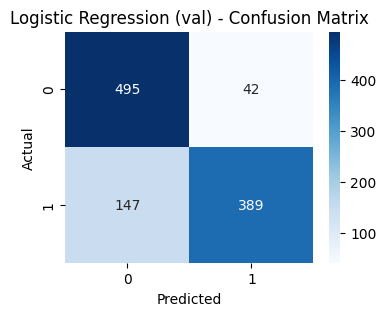

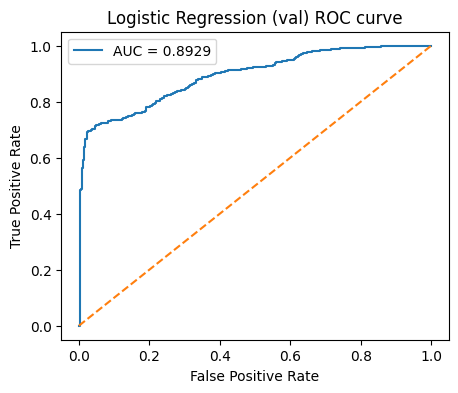


===== Decision Tree (val) =====
              precision    recall  f1-score   support

           0     0.9131    0.9199    0.9165       537
           1     0.9192    0.9123    0.9157       536

    accuracy                         0.9161      1073
   macro avg     0.9161    0.9161    0.9161      1073
weighted avg     0.9161    0.9161    0.9161      1073



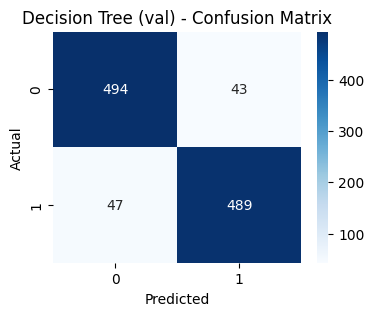

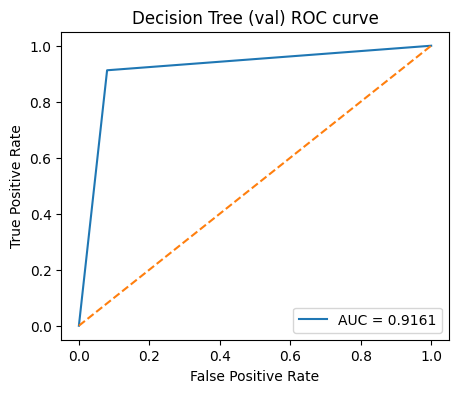


===== Random Forest (val) =====
              precision    recall  f1-score   support

           0     0.9155    0.9683    0.9412       537
           1     0.9663    0.9104    0.9376       536

    accuracy                         0.9394      1073
   macro avg     0.9409    0.9394    0.9394      1073
weighted avg     0.9409    0.9394    0.9394      1073



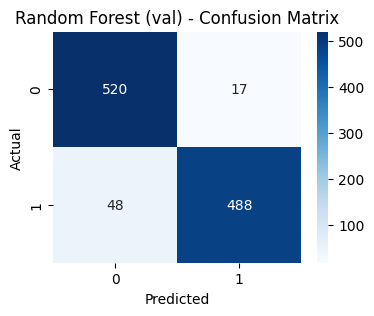

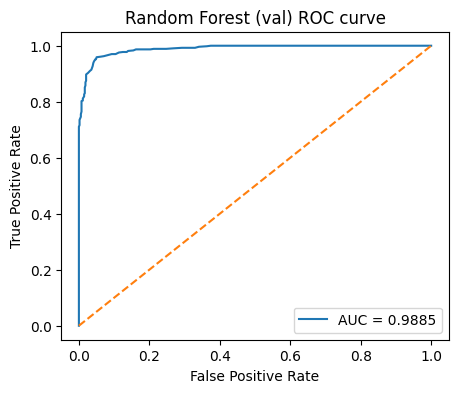

(array([1, 0, 0, ..., 1, 0, 1]),
 array([0.86, 0.36, 0.35, ..., 0.98, 0.38, 0.86]))

In [40]:
print("\n--- Validation set evaluation ---")
evaluate_and_plot("Logistic Regression (val)", log_model, X_valid_scaled, y_valid)
evaluate_and_plot("Decision Tree (val)", dt_model, X_valid_scaled, y_valid)
evaluate_and_plot("Random Forest (val)", rf_model, X_valid_scaled, y_valid)


--- Test set evaluation (real holdout) ---

===== Random Forest (test) =====
              precision    recall  f1-score   support

           0     0.9999    0.9682    0.9838    553574
           1     0.1064    0.9776    0.1919      2145

    accuracy                         0.9682    555719
   macro avg     0.5532    0.9729    0.5879    555719
weighted avg     0.9965    0.9682    0.9807    555719



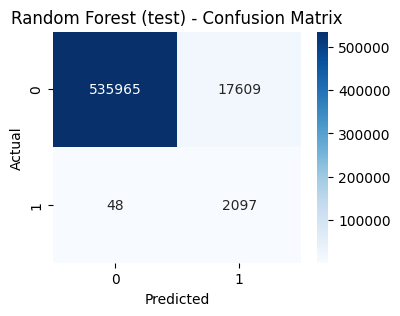

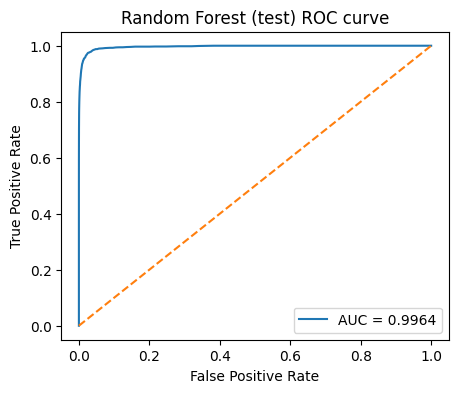

(array([0, 0, 0, ..., 0, 0, 0]),
 array([0.2 , 0.13, 0.08, ..., 0.04, 0.15, 0.06]))

In [41]:
print("\n--- Test set evaluation (real holdout) ---")
evaluate_and_plot("Random Forest (test)", rf_model, X_test_scaled, y_test)


===== Logistic Regression (test) =====
              precision    recall  f1-score   support

           0     0.9990    0.9112    0.9530    553574
           1     0.0320    0.7580    0.0614      2145

    accuracy                         0.9106    555719
   macro avg     0.5155    0.8346    0.5072    555719
weighted avg     0.9952    0.9106    0.9496    555719



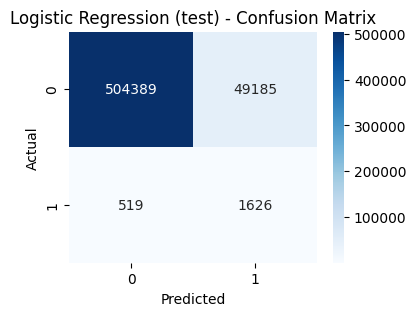

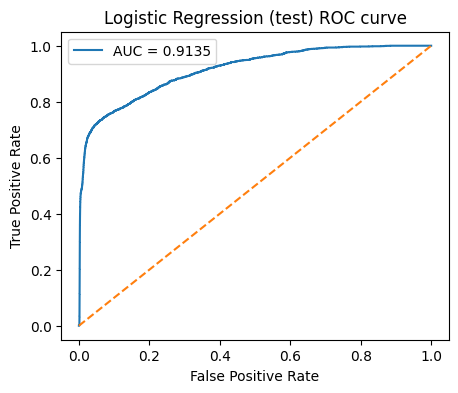


===== Decision Tree (test) =====
              precision    recall  f1-score   support

           0     0.9999    0.9182    0.9573    553574
           1     0.0443    0.9781    0.0847      2145

    accuracy                         0.9184    555719
   macro avg     0.5221    0.9481    0.5210    555719
weighted avg     0.9962    0.9184    0.9539    555719



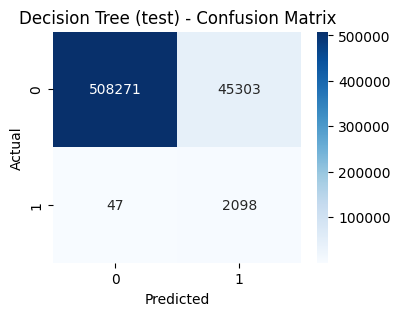

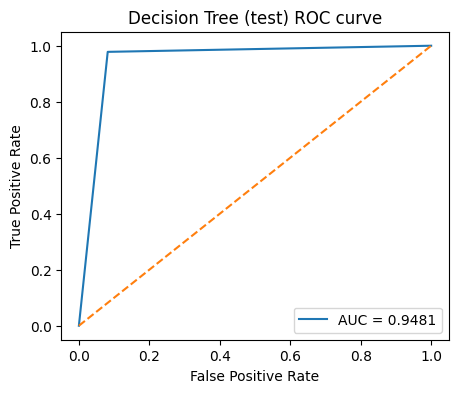

(array([0, 0, 0, ..., 0, 0, 0]), array([0., 0., 0., ..., 0., 0., 0.]))

In [42]:
evaluate_and_plot("Logistic Regression (test)", log_model, X_test_scaled, y_test)
evaluate_and_plot("Decision Tree (test)", dt_model, X_test_scaled, y_test)